# NB1. Spatial map of catchment runoff and river flow
This NB is for quick checking **monthly remapped runoff and routed flow**, not for checking mass conservation for remapped runoff

[1. Some analysis setupt](#setup1)

[2. Loading data](#load_data1)

[3. Spatial mapping](#spatial_map)

In [1]:
%matplotlib inline  
import os, sys
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

from utility import load_toml
from utility import read_shps

import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

print("\nThe Python version: %s.%s.%s" % sys.version_info[:3])
print(xr.__name__, xr.__version__)
print(pd.__name__, pd.__version__)
print(gpd.__name__, gpd.__version__)


The Python version: 3.10.12
xarray 2023.6.0
pandas 2.0.3
geopandas 0.13.2


In [3]:
def no_time_variable(ds):
    """Identify variables without time dimension in netcdf"""
    vars_without_time = []
    for var in ds.variables:
        if 'time' not in ds[var].dims:
            if var not in list(ds.coords):
                vars_without_time.append(var)
    return vars_without_time

-------------------------
## 1. Analysis setup <a id='setup1'></a>

**Please provide CESM case names and ROF grid name, and analysis year and month**

In [4]:
cases = {
        'f09_f09_rHDMAlk_mg17':'rHDMAlk',
        'f09_f09_rHDMAlk_mg17_irrig':'rHDMAlk_irrig',
        }

yr  = 1970
mon = 6

case_name_list = list(cases.keys())
grid_name_list = list(cases.values())

In [2]:
# save geopackage with runoff in attribute?
save_gpkg = False

-------------------------
load config files and some parameters 

In [5]:
setup = load_toml('./setup/setup.toml')

main_dir       = setup['archive_dir']
domain_dir     = setup['ancillary_dir']
geospatial_dir = setup['geospatial_dir']
ref_flow_dir   = setup['ref_flow_dir']

eyr = setup['eyr']
syr = setup['syr']

rof_grid = setup['rof_grid']

reach_gpkg = setup['reach_gpkg']
catch_gpkg = setup['catch_gpkg']

time_period = slice(f"{syr}-01-01",f"{eyr}-12-31") # analysis time period
nyrs = eyr-syr+1  # number of years
nmons = nyrs*12   # number of months

----
## 2. Loading data <a id='load_data1'></a>

### 2.1. Read global HDMA shapefiles 

In [9]:
%%time
gdf_riv = {}
gdf_cat = {}
for grid_name in grid_name_list:
    network  = rof_grid[grid_name]['network']
    riv_gpkg = os.path.join(geospatial_dir, reach_gpkg[network]['file_name'])
    cat_gpkg = os.path.join(geospatial_dir, catch_gpkg[network]['file_name'])

    gdf_riv = read_shps([riv_gpkg], [reach_gpkg[network]['id_name']])
    gdf_cat = read_shps([cat_gpkg], [catch_gpkg[network]['id_name']])

Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_global_stream.shp
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_hydrolake_global_catch_v1_0.01.gpkg
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_global_stream.shp
Finished reading /glade/campaign/ral/hap/mizukami/proj/ctsm-mizuRoute/geospatial/hdma_hydrolake_global_catch_v1_0.01.gpkg
CPU times: user 3min 6s, sys: 3.2 s, total: 3min 9s
Wall time: 3min 19s


### 2.2.  Read monthly/annual flow netCDFs

In [10]:
%%time

reachID    = {}
month_data = {}
year_data  = {}
seas_data  = {}
for case, grid_name in cases.items():
    in_dire = os.path.join(main_dir, case, 'rof/hist')
    model  = rof_grid[grid_name]['model']
    domain = rof_grid[grid_name]['domain_nc']
    #monthly
    month_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.month.nc', data_vars='minimal', chunks={'time':12}).sel(time=time_period).load()
    #annual
    year_data[case] = xr.open_mfdataset(f'{in_dire}/{case}.{model}.*.annual.nc', data_vars='minimal', chunks={'time':1}).sel(time=time_period).load()
    #seasonal (compute here instead of reading because of different time period)
    seas_data[case] = month_data[case].groupby('time.month').mean('time')
    vars_no_time = no_time_variable(month_data[case])
    seas_data[case][vars_no_time] = seas_data[case][vars_no_time].isel(month=0, drop=True)
    
    if domain=='None':  #wish domain = None (not string)
        reachID[case] = month_data[case]['reachID'].values 
    else:
        reachID[case] = xr.open_dataset(f'{domain_dir}/{domain}')['reachID'].values

CPU times: user 13.6 s, sys: 9.38 s, total: 23 s
Wall time: 55.5 s


### 2.3.  Append flow data to shapefile

In [11]:
%%time
# convert xarray to dataframe and append shapefile

df_cat_ro = {}
df_riv_q  = {}

for case, grid_name in cases.items():
    q_var  = rof_grid[grid_name]['flow_name']
    ro_var = rof_grid[grid_name]['runoff_name']

    df_q = month_data[case].set_index(seg='reachID')[q_var].sel(time=f'{yr}-{mon:02}').squeeze(dim='time', drop=True).to_dataframe()
    df_riv_q[case] = pd.merge(gdf_riv, df_q, left_on=reach_gpkg[network]['id_name'], right_index=True)
    df_riv_q[case][q_var] = np.log10(df_riv_q[case][q_var])

    df_ro = month_data[case].set_index(hru='basinID')[ro_var].sel(time=f'{yr}-{mon:02}').squeeze(dim='time', drop=True).to_dataframe()
    df_cat_ro[case] = pd.merge(gdf_cat, df_ro, left_on=catch_gpkg[network]['id_name'], right_index=True)
    df_cat_ro[case][ro_var] = df_cat_ro[case][ro_var]*60*60*24*30  # now mm/mon

CPU times: user 434 ms, sys: 21.1 ms, total: 455 ms
Wall time: 502 ms


## 3. Spatial mapping  <a id='spatial_map'></a>

In [41]:
# create colormaps
# ---------------

cmap = mpl.cm.turbo_r(np.arange(256))
# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])#cmap.shape[0]
cmap.set_under('xkcd:light grey')


cmap2 = LinearSegmentedColormap.from_list('custom blue', 
                                           [(0,     'xkcd:light sky blue'),
                                            (0.25,  'xkcd:cyan'),
                                            (0.75,  'xkcd:blue'),
                                            (1,     'xkcd:royal blue')], N=4)
cmap2.set_under('red')

In [42]:
# some local plot setups
cm = {
      'discharge': cmap,
      'ro':        cmap,
     }

cbar_kwrgs = {"shrink":0.9, "pad":0.090, "orientation": "horizontal", 'extend':'both'}

meta = {
        'ro':        {'vmin':0,  'vmax':200,  'cm':cm['ro']},
        'discharge': {'vmin':-1,  'vmax':4,  'cm':cm['discharge']},
        } 

In [34]:
print(case_name_list)
plot_case = 'f09_f09_rHDMAlk_mg17_irrig'

['f09_f09_rHDMAlk_mg17', 'f09_f09_rHDMAlk_mg17_irrig']


### 3.1 Remapped basin runoff

CPU times: user 1min 37s, sys: 1.32 s, total: 1min 38s
Wall time: 1min 43s


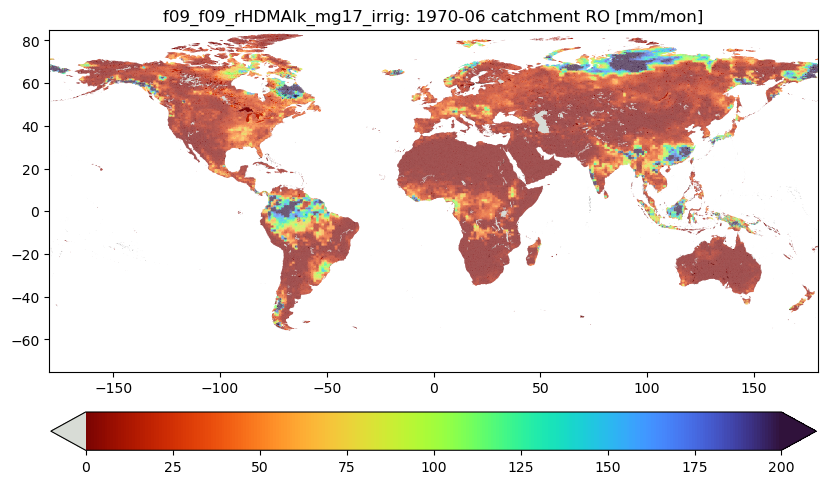

In [39]:
%%time

fig, ax = plt.subplots(1, figsize=(9.0, 5.0))

df_cat_ro[plot_case].plot(ax=ax, column=rof_grid[cases[plot_case]]['runoff_name'], 
                          cmap=meta['ro']['cm'], vmin=meta['ro']['vmin'], vmax=meta['ro']['vmax'], )
ax.set_title(f'{plot_case}: {yr}-{mon:02} catchment RO [mm/mon]')
ax.set_xlim(-180, 180)
ax.set_ylim([-75, 85])

points = ax.collections[0]
plt.colorbar(points, ax=ax, **cbar_kwrgs);

fig.tight_layout()
plt.savefig("./Figures/NB1_ro_catch_%s_%04d-%02d.png"%(plot_case, yr, mon), dpi=150)

if save_gpkg:
    df_cat_ro[plot_case].to_file(f"{cases[plot_case]}_{yr:04}-{mon:02}.gpkg", layer='catch', driver="GPKG")

### 3.2 River flow plots

CPU times: user 33.9 s, sys: 168 ms, total: 34.1 s
Wall time: 35.2 s


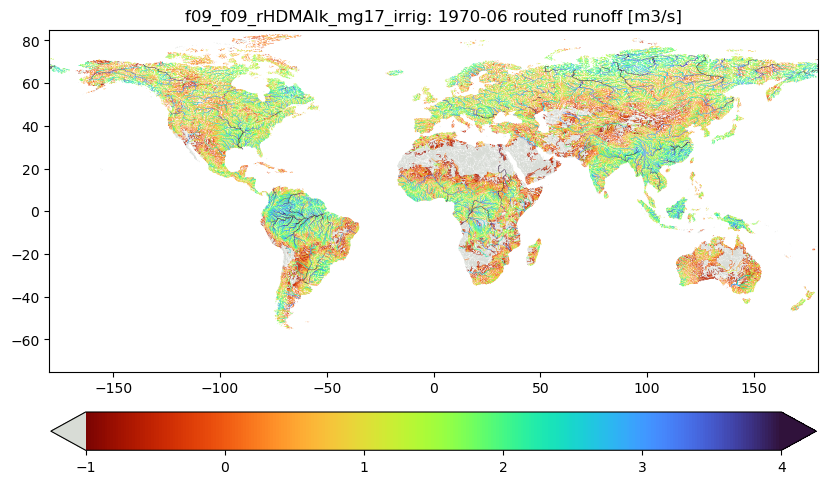

In [38]:
%%time

fig, ax = plt.subplots(1, figsize=(9.0, 5.0))

df_riv_q[plot_case].plot(ax=ax, column=rof_grid[grid_name]['flow_name'], lw=0.3, 
                         cmap=meta['discharge']['cm'], vmin=meta['discharge']['vmin'], vmax=meta['discharge']['vmax'])
ax.set_title(f'{plot_case}: {yr}-{mon:02} routed runoff [m3/s]')
ax.set_xlim([-180, 180])
ax.set_ylim([-75, 85])

points = ax.collections[0]
plt.colorbar(points, ax=ax, **cbar_kwrgs);

fig.tight_layout()
plt.savefig("./Figures/NB1_ro_riv_%s_%04d-%02d.png"%(plot_case, yr, mon), dpi=150)